In [1]:
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataFile = '../Data/us_equities_news_dataset_clean.csv'

In [4]:
dataFrame = pd.read_csv(dataFile)
dataFrame.head(1)

,id,ticker,title,category,content,release_date,provider,url,article_id
0,221515,NIO,shares chinese electric car maker nio flying h...,news,happeningshares chinese electric car maker nio...,2020-01-15,The Motley Fool,https://invst.ly/pigqi,2060327


In [5]:
# columnsDict = dict(zip(dataFrame.columns, [str]*len(dataFrame.columns)))
# columnsDict.pop('Label')
# dataFrame = dataFrame.astype(columnsDict)

In [6]:
#cleanDataFrame = pd.DataFrame()
stockDF = pd.DataFrame(dataFrame.loc[dataFrame['ticker'] == 'AAPL'])
#appleDF = 
stockDF.rename(columns={'release_date':'Date','title':'Text'}, inplace=True)
#sorted(set(appleDF['release_date']))
stockDF.head()

,id,ticker,Text,category,content,Date,provider,url,article_id
49183,270698,AAPL,jpmorgan cautious ahead apple earnings,news,jpmorgan lifts apple aapl 2 9 target 296 300 a...,2020-01-28,Seeking Alpha,https://invst.ly/pnjv8,2068762
49184,270699,AAPL,faang fall get wall street love,news,kim khan investing com faang stocks predictabl...,2020-01-28,Investing.com,https://www.investing.com/news/stock-market-ne...,2068765
49185,270700,AAPL,wall street tumbles virus fuels economic worry,news,chuck mikolajczak new york reuters stocks suff...,2020-01-28,Reuters,https://www.investing.com/news/stock-market-ne...,2068311
49186,270701,AAPL,earnings watch apple amd take earnings stage a...,news,two best performing tech stocks 2019 set repor...,2020-01-28,MarketWatch,https://invst.ly/pnlbs,2068906
49187,270702,AAPL,day ahead top 3 things watch jan 28,news,yasin ebrahim kim khan 1 apple readies earning...,2020-01-28,Investing.com,https://www.investing.com/news/stock-market-ne...,2068907


In [7]:
def dateConvert(input):
    input = input.split('/')
    return input[2]+'-'+input[0]+'-'+input[1]

In [8]:
priceFile = '../Data/HistoricalData_AAPL.csv'
priceDF = pd.read_csv(priceFile, converters={'Date': dateConvert})
priceDF['Label'] = (priceDF['Open'] > priceDF['Close/Last']) * 1
priceDF.head()

,Date,Close/Last,Volume,Open,High,Low,Label
0,2022-12-05,$146.63,68826440,$147.77,$150.9199,$145.77,1
1,2022-12-02,$147.81,65447450,$145.96,$148,$145.65,0
2,2022-12-01,$148.31,71250420,$148.21,$149.13,$146.61,0
3,2022-11-30,$148.03,111380900,$141.395,$148.72,$140.55,0
4,2022-11-29,$141.17,83763800,$144.29,$144.81,$140.355,1


In [9]:
SHUFFLE_SEED = 12345
combinedDF = pd.DataFrame()
combinedDF['Date'] = priceDF['Date']
combinedDF['Label'] = priceDF['Label']
combinedDF = combinedDF.merge(stockDF[['Text','Date']], on='Date')
combinedDF = combinedDF.sample(frac=1, random_state=SHUFFLE_SEED)

In [10]:
N = len(combinedDF)
BATCH_SIZE = 16
TRAIN_PERCENT = 0.8
VALID_PERCENT = 0.2

trainSize = int(N * TRAIN_PERCENT)
validSize = int(trainSize * VALID_PERCENT)

train_df = combinedDF.iloc[:trainSize-validSize]
valid_df = combinedDF.iloc[trainSize-validSize:trainSize]
test_df = combinedDF.iloc[trainSize: N]

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices((train_df['Text'],train_df['Label']))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_df['Text'],valid_df['Label']))
test_ds = tf.data.Dataset.from_tensor_slices((test_df['Text'],test_df['Label']))

train_ds = train_ds.batch(BATCH_SIZE)
valid_ds = valid_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

In [12]:
for text_batch, label_batch in valid_ds.take(1):
  for i in range(1):
    print(f'Review: {text_batch[i]}')
    print(f'Label : {label_batch[i]}')

Review: b'aapl support resistance levels apple 2q earnings report'
Label : 0


In [13]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_ds.map(lambda Text, Label: Text))

In [14]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'apple', 'earnings', 'stock', 'stocks', 'market',
       'tech', 'new', 'china', 'buy', 'top', 'iphone', 'trade', '5',
       'estimates', 'zacks', 'amazon', 'q1', 'growth'], dtype='<U15')

In [15]:
L2_REGULARIZATION = 0.00001

In [16]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION)),
    tf.keras.layers.Dense(1)
])

In [17]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 1s 1s/step
[0.00191475]


In [18]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 73ms/step
[0.00191475]


In [19]:
EPOCHS = 5
VALIDATION_STEPS = 10
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer=tf.keras.optimizers.Adam(1e-2)
#metrics = tf.metrics.BinaryAccuracy()
metrics = [tf.keras.metrics.BinaryCrossentropy(from_logits=True, name='binary_crossentropy'), 'accuracy']

In [20]:
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [21]:
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=test_ds,
                    validation_steps=VALIDATION_STEPS)

Epoch 1/5
700/700 [==============================] - 7s 5ms/step - loss: 0.6917 - binary_crossentropy: 0.6903 - accuracy: 0.5464 - val_loss: 0.6818 - val_binary_crossentropy: 0.6812 - val_accuracy: 0.5875
Epoch 2/5
700/700 [==============================] - 3s 4ms/step - loss: 0.6958 - binary_crossentropy: 0.6892 - accuracy: 0.5466 - val_loss: 0.6812 - val_binary_crossentropy: 0.6792 - val_accuracy: 0.5875
Epoch 3/5
700/700 [==============================] - 2s 4ms/step - loss: 0.6966 - binary_crossentropy: 0.6856 - accuracy: 0.5544 - val_loss: 0.6845 - val_binary_crossentropy: 0.6795 - val_accuracy: 0.5875
Epoch 4/5
700/700 [==============================] - 2s 3ms/step - loss: 0.6965 - binary_crossentropy: 0.6833 - accuracy: 0.5592 - val_loss: 0.6931 - val_binary_crossentropy: 0.6857 - val_accuracy: 0.5875
Epoch 5/5
700/700 [==============================] - 2s 3ms/step - loss: 0.6976 - binary_crossentropy: 0.6804 - accuracy: 0.5639 - val_loss: 0.6906 - val_binary_crossentropy: 0.678

In [22]:
test_loss, test_bin, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Binary Cross Entropy:', test_bin)
print('Test Accuracy:', test_acc)

219/219 [==============================] - 0s 1ms/step - loss: 0.7023 - binary_crossentropy: 0.6905 - accuracy: 0.5417
Test Loss: 0.7022700309753418
Test Binary Cross Entropy: 0.6905247569084167
Test Accuracy: 0.5417381525039673


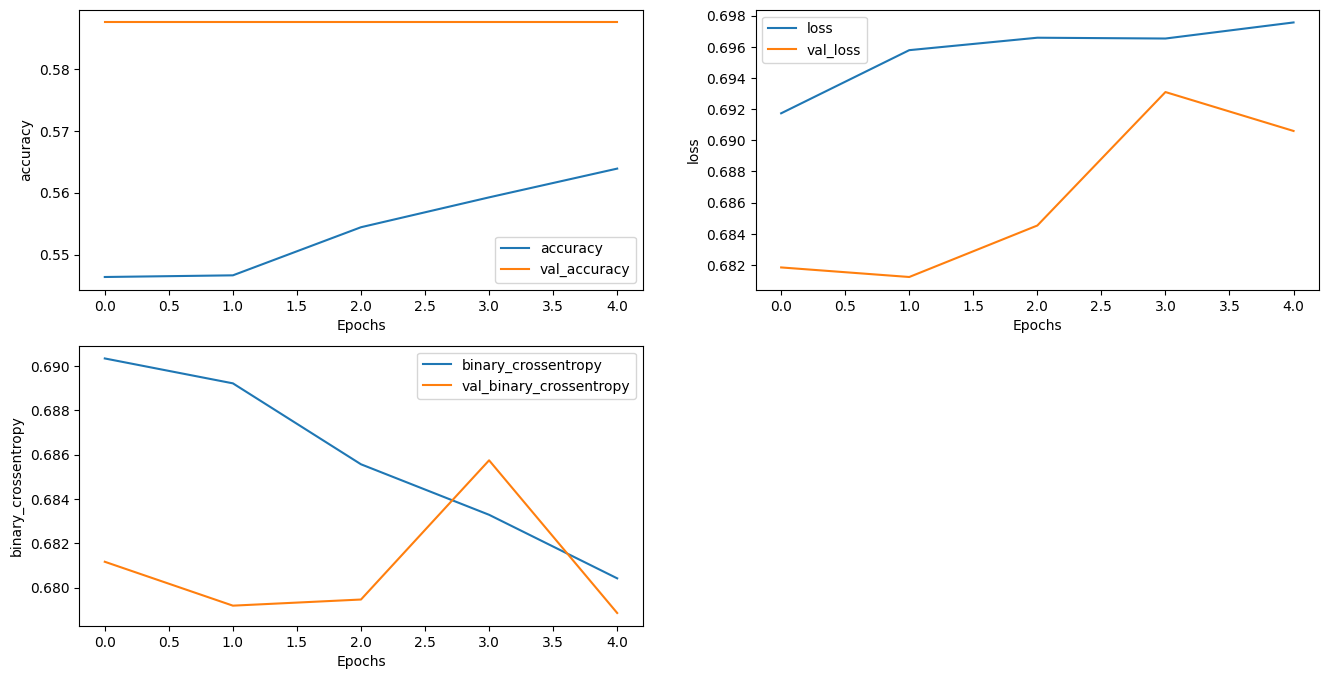

In [23]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plot_graphs(history, 'accuracy')
#plt.ylim(None, 1)
plt.subplot(2, 2, 2)
plot_graphs(history, 'loss')
#plt.ylim(0, None)
plt.subplot(2, 2, 3)
plot_graphs(history, 'binary_crossentropy')
#plt.ylim(0, None)

In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION))),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [25]:
model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

In [26]:
history = model.fit(train_ds, epochs=EPOCHS,
                    validation_data=test_ds,
                    validation_steps=VALIDATION_STEPS)

Epoch 1/5
700/700 [==============================] - 13s 9ms/step - loss: 0.7205 - binary_crossentropy: 0.6928 - accuracy: 0.5465 - val_loss: 0.6850 - val_binary_crossentropy: 0.6786 - val_accuracy: 0.5875
Epoch 2/5
700/700 [==============================] - 4s 6ms/step - loss: 0.6929 - binary_crossentropy: 0.6894 - accuracy: 0.5464 - val_loss: 0.6805 - val_binary_crossentropy: 0.6789 - val_accuracy: 0.5875
Epoch 3/5
700/700 [==============================] - 4s 6ms/step - loss: 0.6902 - binary_crossentropy: 0.6892 - accuracy: 0.5464 - val_loss: 0.6796 - val_binary_crossentropy: 0.6791 - val_accuracy: 0.5875
Epoch 4/5
700/700 [==============================] - 4s 6ms/step - loss: 0.6895 - binary_crossentropy: 0.6892 - accuracy: 0.5464 - val_loss: 0.6793 - val_binary_crossentropy: 0.6791 - val_accuracy: 0.5875
Epoch 5/5
700/700 [==============================] - 4s 6ms/step - loss: 0.6893 - binary_crossentropy: 0.6892 - accuracy: 0.5464 - val_loss: 0.6792 - val_binary_crossentropy: 0.67

In [27]:
test_loss, test_bin, test_acc = model.evaluate(test_ds)

print('Test Loss:', test_loss)
print('Test Binary Cross Entropy:', test_bin)
print('Test Accuracy:', test_acc)

219/219 [==============================] - 0s 2ms/step - loss: 0.6905 - binary_crossentropy: 0.6904 - accuracy: 0.5417
Test Loss: 0.6905114054679871
Test Binary Cross Entropy: 0.6904446482658386
Test Accuracy: 0.5417381525039673


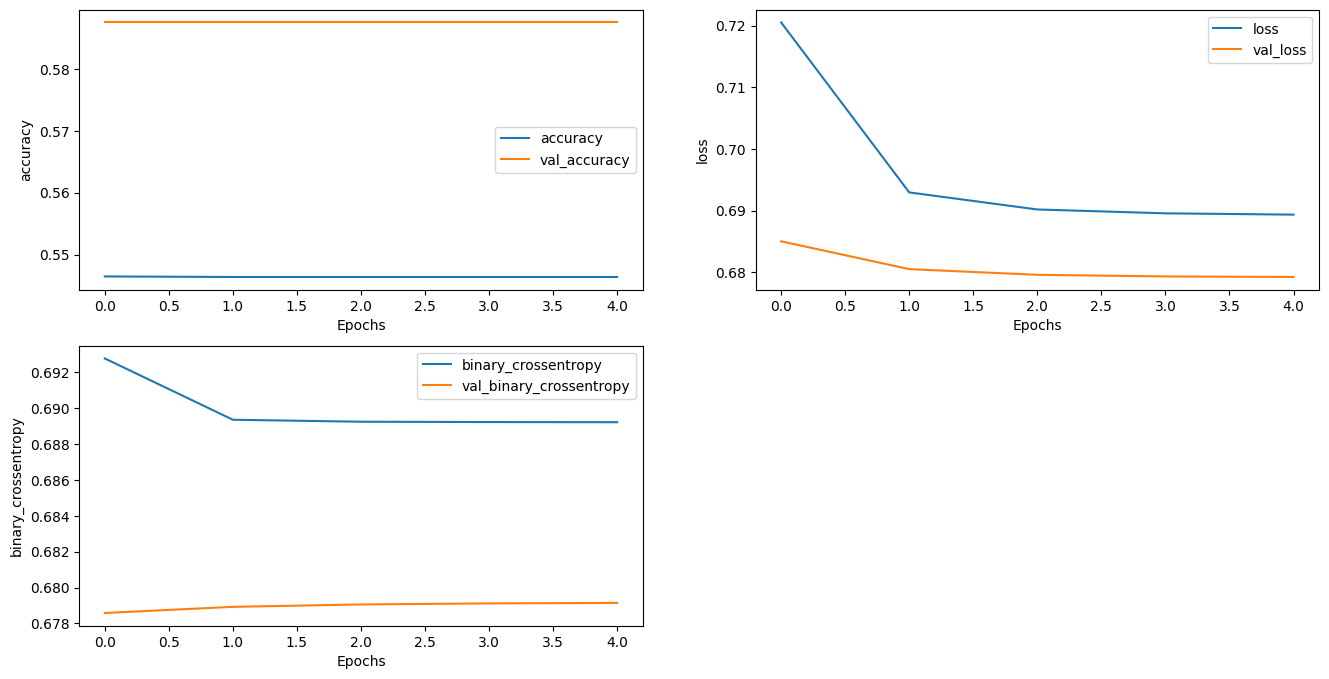

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plot_graphs(history, 'accuracy')
#plt.ylim(None, 1)
plt.subplot(2, 2, 2)
plot_graphs(history, 'loss')
#plt.ylim(0, None)
plt.subplot(2, 2, 3)
plot_graphs(history, 'binary_crossentropy')
#plt.ylim(0, None)